In [2]:
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

import tensorflow as tf
from tensorflow import keras
from keras import preprocessing
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.models import Model
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D
import transformers as ppb # pytorch-pretrained-bert
# from transformers import_version_; print(_version_)
from transformers import BertTokenizer
from transformers import BertModel, BertForMaskedLM
import torch
import pipeline as pp
import models as ml
import numpy as np
import pandas as pd
import importlib

# import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

2023-03-28 14:44:16.356131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Generate dataset

Generate dataset and apply binary labels to the data.

In [51]:
importlib.reload(pp)


data = pp.apply_pipeline(
    '../datasets/sample/dataset.csv',
    [(pp.Binary_labels(), 'type', 'typeContent') ],
    # classes=[True, False],
    total_rows=5000,
    new_file='../datasets/sample/dataset_bin_raw.csv',
    progress_bar=True,
)

# write panda frame data to ../datasets/big/dataset_bin.csv"

raw_sample_file = '../datasets/sample/dataset_bin_raw.csv'


100%|██████████| 5000/5000 [00:00<00:00, 1177579.88it/s]


processed 20000 rows
finish time: 0.402724027633667


In [66]:
pd.read_csv('../datasets/sample/dataset_bin_raw.csv')

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source,typeContent
0,6301449,nytimes.com,reliable,https://query.nytimes.com/gst/fullpage.html?re...,\n\nTo the Editor:\n\nRe ''Drop Out of the Col...,2018-02-11 00:40:10.316783,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,Time to Scrap the Electoral College?,NaN,NaN,"['Presidential Elections (US)', 'Electoral Col...",<br>To the Editor:\n<p>\n Re ''Drop Out of th...,NaN,NaN,nytimes,True
1,3676064,nationalreview.com,political,http://www.nationalreview.com/postmodern-conse...,So I’ve written for another channel my advice ...,2017-11-27T01:14:42.983556,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,"Antonin Scalia, Donald Trump, Tyler Cowen & Co...",Peter Augustine Lawler,NaN,['Peter Augustine Lawler'],Senate Republicans should enter into the battl...,NaN,NaN,NaN,True
2,5192554,infowars.com,conspiracy,https://www.infowars.com/soldiers-nearly-kille...,"David Gutierrez\n\nNatural News\n\nNovember 3,...",2017-12-09T22:10:08.302997,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Soldiers Nearly Killed with Military’s Bioterr...,NaN,NaN,[''],NaN,NaN,NaN,NaN,False
3,1136409,redstate.com,political,https://www.redstate.com/diary/Erick/2010/10/2...,Colorado should not be too close to call right...,2017-11-10T11:18:44.524042,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Colorado Should Not Be Too Close To Call,"Erick Erickson, Redstate Insider, Susan Wright...",NaN,[''],Colorado Should Not Be Too Close To Call,"Michael Bennet, Colorado, ken buck",NaN,NaN,True
4,62174,beforeitsnews.com,fake,http://beforeitsnews.com/survival/2015/06/lett...,Letter Re: Does the Number of the Beast Have a...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Letter Re: Does the Number of the Beast Have a...,NaN,NaN,[''],NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4692181,beforeitsnews.com,fake,http://beforeitsnews.com/spirit/2016/11/thane-...,Two remote villages in neighbouring Thane dist...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Thane villages get rid of darkness this Diwali,Wisdom Blog Of Art Of Living,NaN,[''],NaN,NaN,NaN,NaN,False
4996,1308332,chroniclesmagazine.org,political,http://www.chroniclesmagazine.org/1998/Februar...,Peter LaBabera is publisher of the Lambda Repo...,2017-11-10T11:18:44.524042,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Chronicles Magazine,NaN,NaN,[''],NaN,NaN,NaN,NaN,True
4997,6505182,nytimes.com,reliable,https://query.nytimes.com/gst/fullpage.html?re...,SAINT-SA?: PIANO CONCERTOS NOS. 2 & 5; FRANCK:...,2018-02-11 00:42:12.085863,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,"Classical Recordings: Ambient Haze, Romanticis...",NaN,NaN,[''],SAINT-SA�NS: PIANO CONCERTOS NOS. 2 & 5; FRANC...,NaN,NaN,nytimes,True
4998,73138,beforeitsnews.com,fake,http://beforeitsnews.com/opinion-conservative/...,"Barack and the Terrible, Horrible, No Good, Ve...",2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Barack and the Terrible, Horrible, No Good, Ve...",NaN,NaN,[''],NaN,NaN,NaN,NaN,False


## Clean data

In [76]:
importlib.reload(pp)

def Clean_data(file, new_file, content="content"):
    stopwords_lst = stopwords.words('english')
    pp.apply_pipeline(file, [
            # Clean content
            (pp.Clean_data(), content, "content_cleaned"),
            (pp.Tokenizer(), "content_cleaned", "content_tokenized"),
            (pp.Remove_stopwords(stopwords_lst), "content_tokenized"),
            (pp.Stem(), "content_tokenized"),
            (pp.Combine_Content(), "content_tokenized", "content_combined"), # join all the words in the list to a string
            # Clean authors
            # (pp.Clean_author(), "authors"),
            # # Clean title
            # (pp.Clean_data(), 'title'),
            # (pp.Tokenizer(), "title"),
            # (pp.Remove_stopwords(stopwords_lst), "title"),
            # (pp.Stem(), "title"),
            # (pp.Combine_Content(), "title"),
            # # Clean domain
            # (pp.Clean_domain(), 'domain'),
            # Combine columns (used as features)
            # (pp.Join_str_columns(["content_combined", "authors"]), None, "content_authors"),
            # (pp.Join_str_columns(["content_combined", "title"]), None, "content_title"),
            # (pp.Join_str_columns(["content_combined", "domain"]), None, "content_domain"),
            # (pp.Join_str_columns(["content_combined", "domain", "authors", "title"]), None, "content_domain_authors_title")
        ],
        new_file=new_file,
        progress_bar=True,
    )



Clean_data(raw_sample_file, "../datasets/big/dataset_unbalanced_cleaned.csv")
cleaned_content_list = "content_tokenized"
cleaned_content_string = "content_combined"
# cleaned_data = pd.read_csv("../datasets/big/dataset_unbalanced_cleaned.csv")



100%|██████████| 5000/5000 [00:00<00:00, 145619.38it/s]


processed 20000 rows
finish time: 31.504063844680786


# Split the data to training set

In [77]:

fromfile = "../datasets/big/dataset_unbalanced_cleaned.csv"

pp.get_dataframe_with_distribution(fromfile, 5000, [0.8,0.1,0.1], [False, False, False], 
                                   out_file="../datasets/sample/dataset_unbalanced.csv", get_frame=False)

cleaned_data = pd.read_csv("../datasets/sample/dataset_unbalanced.csv")

100%|██████████| 5000/5000 [00:00<00:00, 891115.83it/s]


entries to read: 0
entries read: 20000


In [79]:
len(cleaned_data)

5000

## Cluster the data (optional)

To find underlying clusters in the data, we use the KMeans algorithm.


In [89]:
# Vectorize the corpus using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(cleaned_data['content_combined'].values.astype('U'))

### Plot the elbow curve to determine the optimal number of clusters.

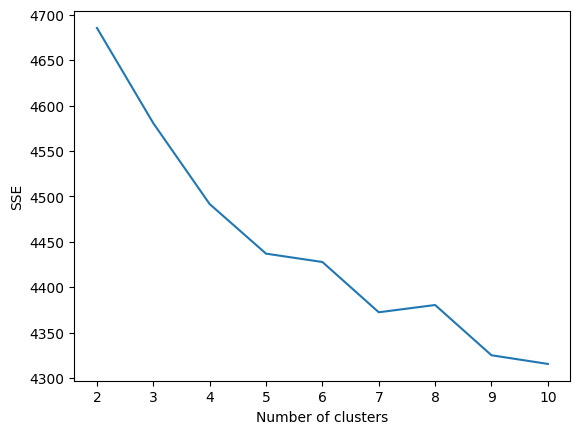

In [90]:
# Calculate SSE for different values of k
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

models = []

sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(tfidf)
    models.append(kmeans)
    sse[k] = kmeans.inertia_ 

# Plot SSE against k
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

### Define the number of clusters

In [91]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=10)
kmeans.fit(tfidf)

KMeans(max_iter=100, n_clusters=5, n_init=10)

### Plot the clusters using a a scatterplot in 2d with PCA.

In [92]:
label_to_color = {0: 'red', 1: 'blue', 2: 'green', 3: 'violet', 4: "yellow", 5: "orange"}

In [ ]:
from sklearn.decomposition import PCA

# Reduce the dimensions of the data using PCA
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(tfidf.toarray())

colors = [label_to_color[label] for label in kmeans.labels_]

# Visualize the clusters
plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], 
            c=colors, 
            cmap='rainbow',
            )
plt.show()

In [93]:
# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] # sort the centroids by their distance to the origin
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
    print()

Top terms per cluster:
Cluster red terms: num, date, url, said, new, time, mr, peopl, state, year, 
Cluster blue terms: updat, bookmark, sputnik, pleas, dear, excit, radio, whitelist, adblock, voic, 
Cluster green terms: tor, tail, anonymis, usb, browser, dvd, submiss, stick, comput, internet, 
Cluster violet terms: rec, num, trump, republican, moor, date, diari, roy, senat, thread, 
Cluster yellow terms: iran, iranian, nuclear, suprem, islam, minist, leader, tehran, ali, republ, 


### Add the cluster labels to the data as a feature

In [150]:
cleaned_data['cluster'] = kmeans.labels_
# add the cluster label to the content

# concat the cluster label to the content

# create a new column 'cluster_color' that maps cluster labels to color codes
cleaned_data['cluster_color'] = cleaned_data['cluster'].map(label_to_color)

# create a new column 'cluster_string' that concatenates the color code and cluster label string
cleaned_data['cluster_string'] = cleaned_data['cluster_color'] + 'Cluster'

cleaned_data['content_with_cluster'] = cleaned_data['content_combined'] + ' ' + cleaned_data['cluster_string'].astype(str)

In [151]:
cleaned_data['content_with_cluster'][0]

'editor drop colleg editori march <num> written favor elector colleg reform sinc <date> would prefer popular elect presid gimmick endors individu state bind elector vote nation popularvot winner seem problemat one basic reason stop state legislatur strong partisan loyalti abandon agreement urgent calcul parti advantag come fore ? one legislatur anoth undo end difficult might presidentialelect reform depend take amend process serious that exampl editori cite conclus demonstr although individu state set legisl preced grant suffrag africanamerican women also popular elect senat end right entrench constitut amend left unstabl legisl gimmickri jack rakov stanford calif march <date> writer professor histori american studi polit scienc stanford univers draw draw thoma fuch redCluster'

### Add top termas as features

In [129]:
# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] # sort the centroids by their distance to the origin
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    top_terms = ', '.join([terms[j] for j in order_centroids[i, :10]]).replace(',', '')
    print(top_terms)
    cleaned_data.loc[cleaned_data['cluster'] == i, 'content_with_top_terms'] = cleaned_data.loc[cleaned_data['cluster'] == i, 'content_combined'] + ' ' + top_terms

# write data to csv
# cleaned_data.to_csv("../datasets/sample/dataset_unbalanced_with_clusters.csv", index=False)

Top terms per cluster:
Cluster red terms: num date url said new time mr peopl state year
Cluster blue terms: updat bookmark sputnik pleas dear excit radio whitelist adblock voic
Cluster green terms: tor tail anonymis usb browser dvd submiss stick comput internet
Cluster violet terms: rec num trump republican moor date diari roy senat thread
Cluster yellow terms: iran iranian nuclear suprem islam minist leader tehran ali republ


In [115]:
# Clean_data("../datasets/sample/dataset_unbalanced_with_clusters.csv", "../datasets/big/dataset_unbalanced_cleaned.csv")
# cleaned_content_list = "content_tokenized"
# cleaned_content_string = "content_combined"

100%|██████████| 5000/5000 [00:00<00:00, 160401.40it/s]


processed 20000 rows
finish time: 33.5052752494812


In [130]:
# cleaned_data.head(1)
cleaned_data.iloc[0]['content_with_top_terms']

'editor drop colleg editori march <num> written favor elector colleg reform sinc <date> would prefer popular elect presid gimmick endors individu state bind elector vote nation popularvot winner seem problemat one basic reason stop state legislatur strong partisan loyalti abandon agreement urgent calcul parti advantag come fore ? one legislatur anoth undo end difficult might presidentialelect reform depend take amend process serious that exampl editori cite conclus demonstr although individu state set legisl preced grant suffrag africanamerican women also popular elect senat end right entrench constitut amend left unstabl legisl gimmickri jack rakov stanford calif march <date> writer professor histori american studi polit scienc stanford univers draw draw thoma fuch num date url said new time mr peopl state year'

### Get balanced or unbalanced dataset

In [34]:
# importlib.reload(pp)
# from_file = '../datasets/sample/dataset_bin_raw.csv'
# # from_file = '../datasets/sample/news_sample_cleaned_num_100k.csv'
# TOTALSIZE = 5000

# pp.get_dataframe_with_distribution(
#         from_file, 
#         total_size = TOTALSIZE, 
#         splits=[0.8,0.1,0.1], 
#         balanced=[False, False, False], 
#         out_file="../datasets/big/dataset_unbalanced.csv", 
#         get_frame=False
#     )



100%|██████████| 5000/5000 [00:00<00:00, 961026.49it/s]


entries to read: 0
entries read: 20000


In [78]:
pd.read_csv("../datasets/big/dataset_unbalanced_cleaned.csv").iloc[0]["content_tokenized"]

"['editor', 'drop', 'colleg', 'editori', 'march', '<num>', 'written', 'favor', 'elector', 'colleg', 'reform', 'sinc', '<date>', 'would', 'prefer', 'popular', 'elect', 'presid', 'gimmick', 'endors', 'individu', 'state', 'bind', 'elector', 'vote', 'nation', 'popularvot', 'winner', 'seem', 'problemat', 'one', 'basic', 'reason', 'stop', 'state', 'legislatur', 'strong', 'partisan', 'loyalti', 'abandon', 'agreement', 'urgent', 'calcul', 'parti', 'advantag', 'come', 'fore', '?', 'one', 'legislatur', 'anoth', 'undo', 'end', 'difficult', 'might', 'presidentialelect', 'reform', 'depend', 'take', 'amend', 'process', 'serious', 'that', 'exampl', 'editori', 'cite', 'conclus', 'demonstr', 'although', 'individu', 'state', 'set', 'legisl', 'preced', 'grant', 'suffrag', 'africanamerican', 'women', 'also', 'popular', 'elect', 'senat', 'end', 'right', 'entrench', 'constitut', 'amend', 'left', 'unstabl', 'legisl', 'gimmickri', 'jack', 'rakov', 'stanford', 'calif', 'march', '<date>', 'writer', 'professor',

# Define the model

### Define function to split the data

# Model A

In [12]:
df = pd.read_csv("../datasets/sample/dataset_unbalanced.csv")

In [16]:
X = df['content'].values
y = df['type_binary'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [18]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [22]:
max_len = 500
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [25]:
model = tf.keras.Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_len),
    LSTM(units=64, dropout=0.2, recurrent_dropout=0.2),
    Dense(units=1, activation='sigmoid')
])

In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test))

Epoch 1/10
125/125 [==============================] - 35s 257ms/step - loss: 0.5595 - accuracy: 0.7103 - val_loss: 0.4562 - val_accuracy: 0.7710
Epoch 2/10
125/125 [==============================] - 34s 271ms/step - loss: 0.3328 - accuracy: 0.8580 - val_loss: 0.4303 - val_accuracy: 0.8040
Epoch 3/10
125/125 [==============================] - 32s 260ms/step - loss: 0.1814 - accuracy: 0.9283 - val_loss: 0.5382 - val_accuracy: 0.7870
Epoch 4/10
125/125 [==============================] - 34s 271ms/step - loss: 0.0855 - accuracy: 0.9728 - val_loss: 0.6164 - val_accuracy: 0.7870
Epoch 5/10
125/125 [==============================] - 36s 290ms/step - loss: 0.0363 - accuracy: 0.9905 - val_loss: 0.8345 - val_accuracy: 0.7890
Epoch 6/10
125/125 [==============================] - 38s 308ms/step - loss: 0.0619 - accuracy: 0.9790 - val_loss: 0.6924 - val_accuracy: 0.7640
Epoch 7/10
125/125 [==============================] - 36s 291ms/step - loss: 0.0588 - accuracy: 0.9785 - val_loss: 0.8416 - val_ac

In [ ]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Model B - tensorflow (word embedding, neural network)

### Tokenize the data and make sequences

In [152]:
# Split data into training and testing sets
# df = pd.read_csv("../datasets/big/dataset_unbalanced_cleaned.csv")

# working_file = "../datasets/big/dataset_unbalanced_cleaned.csv"
# pd.read_csv(working_file).head()

df = cleaned_data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

# content cleaned
# tokenizer.fit_on_texts(df[df["set"] == 0]["content_cleaned"])
# sequences = tokenizer.texts_to_sequences(df["content_cleaned"])
# df["padded_sequences"] = pad_sequences(sequences, maxlen=1000, truncating="post").tolist()

# col = "content_with_top_terms"
col = "content_with_cluster"

# col = "content_combined"


# all cleaned
tokenizer.fit_on_texts(df[df["set"] == 0][col])
sequences = tokenizer.texts_to_sequences(df[col])
df["padded_sequences_all"] = pad_sequences(sequences, maxlen=1000, truncating="post").tolist()


### Create CSR (Compressed Sparse Row) matrix to use in models

The function first splits the input data into three sets based on the values in the set column: a training set (where set=0), a validation set (where set=1), and a test set (where set=2).

Next, the function applies the stack_func stacking function to the feature column of each set of data to convert it into a CSR (Compressed Sparse Row) matrix. A CSR matrix is a sparse matrix format that stores data in a compressed way, which can be more memory-efficient than other formats for sparse data.

The function also converts the y column of each set of data into an integer type.

In [154]:
def split_csr_data(data: pd.DataFrame, feature: str, y, stack_func, set="set", get_val=True):
    # train = data[data[set] == 0]
    # val = data[data[set] == 1]
    # test = data[data[set] == 2]
    
    train = data[data[set] == 0]
    val = data[data[set] == 1]
    test = data[data[set] == 2]

    X_train, y_train = stack_func(train[feature]), train[y].astype(int)
    X_val, y_val = stack_func(val[feature]), val[y].astype(int)
    X_test, y_test = stack_func(test[feature]), test[y].astype(int)
    if not get_val:
        return X_train, X_test, y_train, y_test
    return X_train, X_val, X_test, y_train, y_val, y_test

In [155]:
X_train_stacked, X_val_stacked, X_test_stacked, y_train_stacked, y_val_stacked, y_test_stacked = split_csr_data(
    df, 
    "padded_sequences_all", "typeContent", 
    lambda x: np.array(x.tolist()), 
    get_val=True
    )

In [162]:
# Define the model architecture
models = [
    (tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=1000),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]), "Model-A"),
    # Results: [0.4473037123680115, 0.777999997138977]
    # Results: [0.4245592951774597, 0.7940000295639038]
    # Results: [0.4389077126979828, 0.7860000133514404,

    (tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=1000), # 10000 words, 64 dimensions
        tf.keras.layers.LSTM(units=16, dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ]), "Model-B"),
    # Results: [0.6940779685974121, 0.7940000295639038]

    # (tf.keras.Sequential([
    #     tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=1000), # 10000 words, 64 dimensions
    #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=16, dropout=0.2, recurrent_dropout=0.2)),
    #     tf.keras.layers.Dense(units=1, activation='sigmoid')
    # ]), "Model-C"), bad


    (tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=1000), # 10000 words, 64 dimensions
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(100),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='sigmoid')
    ]), "Model-D")
    # Results: [0.9893674254417419, 0.7720000147819519]

]

modelIndex = 0
# Compile the model
# for model, name in models:
for model, name in [models[modelIndex]]:
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])



# for feature in ["padded_sequences", "padded_sequences_all"]:
# print("Training model with feature: {}".format(feature))
# X_train, X_val, X_test, y_train, y_val, y_test = split_csr_data(df, "padded_sequences_all", "typeContent", lambda x: np.array(x.tolist()), get_val=True)

# for model, name in models:
for model, name in [models[modelIndex]]:
    print(f"Training {name}")
    # Train the model
    model.fit(X_train_stacked, y_train_stacked, epochs=10, validation_data=(X_val_stacked, y_val_stacked))

    # Evaluate the model
    print(f"Results:", model.evaluate(X_test_stacked, y_test_stacked))

# for feature in ["padded_sequences", "padded_sequences_all"]:
#     print("Training model with feature: {}".format(feature))
#     X_train, X_val, X_test, y_train, y_val, y_test = split_csr_data(df, feature, "typeContent", lambda x: np.array(x.tolist()), get_val=True)

#     for model, name in models:
#         print(f"Training {name}")
#         # Train the model
#         model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

#         # Evaluate the model
#         print(f"Results:", model.evaluate(X_test, y_test))


Training Model-A
Epoch 1/10
125/125 [==============================] - 1s 5ms/step - loss: 0.6885 - accuracy: 0.5717 - precision: 0.5683 - recall: 0.6601 - val_loss: 0.6852 - val_accuracy: 0.5560 - val_precision: 0.7143 - val_recall: 0.3819
Epoch 2/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6392 - precision: 0.6878 - recall: 0.5334 - val_loss: 0.6630 - val_accuracy: 0.5840 - val_precision: 0.7532 - val_recall: 0.4132
Epoch 3/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6615 - precision: 0.7153 - recall: 0.5565 - val_loss: 0.6068 - val_accuracy: 0.6580 - val_precision: 0.7940 - val_recall: 0.5486
Epoch 4/10
125/125 [==============================] - 1s 5ms/step - loss: 0.5508 - accuracy: 0.7355 - precision: 0.8135 - recall: 0.6233 - val_loss: 0.5654 - val_accuracy: 0.6740 - val_precision: 0.8882 - val_recall: 0.4965
Epoch 5/10
125/125 [==============================] - 0s 3ms/step - loss: 0.4886 - accu

TypeError: 'Sequential' object is not subscriptable

# Most successful model from list

In [84]:


# Define the model architecture
# model = tf.keras.Sequential([
#     Embedding(input_dim=5000, output_dim=64, input_length=1000),
#     LSTM(units=64, dropout=0.2, recurrent_dropout=0.2),
#     Dense(units=1, activation='sigmoid')
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=1000), # 10000 words, 64 dimensions
    tf.keras.layers.LSTM(units=16, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])



# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train_stacked, y_train_stacked, epochs=10, validation_data=(X_val_stacked, y_val_stacked))

# Evaluate the model
# model.evaluate(X_test, y_test)

model.evaluate(X_test_stacked, y_test_stacked)


# [0.23643802106380463, 0.9100000262260437]


# [0.8935213685035706, 0.7739999890327454]

Epoch 1/10
125/125 [==============================] - 41s 318ms/step - loss: 0.6214 - accuracy: 0.6715 - val_loss: 0.5209 - val_accuracy: 0.7740
Epoch 2/10
125/125 [==============================] - 39s 309ms/step - loss: 0.4058 - accuracy: 0.8257 - val_loss: 0.4422 - val_accuracy: 0.7960
Epoch 3/10
125/125 [==============================] - 39s 308ms/step - loss: 0.2533 - accuracy: 0.9118 - val_loss: 0.5376 - val_accuracy: 0.7900
Epoch 4/10
125/125 [==============================] - 39s 309ms/step - loss: 0.1646 - accuracy: 0.9433 - val_loss: 0.5695 - val_accuracy: 0.7920
Epoch 5/10
125/125 [==============================] - 39s 310ms/step - loss: 0.1021 - accuracy: 0.9695 - val_loss: 0.6770 - val_accuracy: 0.7760
Epoch 6/10
125/125 [==============================] - 39s 313ms/step - loss: 0.0771 - accuracy: 0.9775 - val_loss: 0.8155 - val_accuracy: 0.7800
Epoch 7/10
125/125 [==============================] - 39s 316ms/step - loss: 0.0543 - accuracy: 0.9845 - val_loss: 0.6902 - val_ac

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [135]:
model.evaluate(X_test_stacked, y_test_stacked)

16/16 [==============================] - 1s 61ms/step - loss: 0.8279 - accuracy: 0.7780


[0.8278565406799316, 0.777999997138977]

In [138]:
# import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


def print_scores(model, X_test, y_test, X_train, y_train): # add model, or filepath (and load) here?
    #model = keras.models.load_model(best_model_file_name)
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    y_pred_train = (model.predict(X_train) > 0.5).astype("int32")
    print("Scores for ", model)
    print('Accuracy Train: ', accuracy_score(y_train, y_pred_train))
    print('Accuracy Test: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1 Score: ', f1_score(y_test, y_pred))


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [137]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 1000, 16)          160000    
                                                                 
 lstm_7 (LSTM)               (None, 16)                2112      
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 162,129
Trainable params: 162,129
Non-trainable params: 0
_________________________________________________________________


Our model has 162,129 parameters to train which means 162,129 partial gradients to calculate and optimize for each epoch. Clearly, the optimization problem is is going to have numerous local minima and look something like this:


# Support vector machine

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
X_train, X_val, X_test, y_train, y_val, y_test = split_csr_data(df, "padded_sequences_all", "typeContent", lambda x: np.array(x.tolist()), get_val=True)


vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train['content_domain_authors_title'])
X_test = vectorizer.transform(X_test['content_domain_authors_title'])


# create SVM model
clf = SVC(kernel='linear')

# fit the model to the training data
clf.fit(X_train, y_train)

# make predictions on the testing data
y_pred = clf.predict(X_test)

# calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# print the accuracy score
print("Accuracy:", accuracy)

In [93]:
pdf1 = pd.read_csv("../datasets/sample/dataset_unbalanced.csv")
pdf2 = pp.apply_pipeline_pd_tqdm(pdf1, [(pp.Tokenizer(), "content", "tokenized")])

100%|██████████| 5000/5000 [00:00<00:00, 15719.50it/s]


In [94]:
list = []
_ = pdf2["tokenized"].apply(lambda x: list.extend(x))

In [96]:
list

['To',
 'the',
 'Editor:',
 'Re',
 "''Drop",
 'Out',
 'of',
 'the',
 "College''",
 '(editorial,',
 'March',
 '14):',
 'Having',
 'written',
 'in',
 'favor',
 'of',
 'Electoral',
 'College',
 'reform',
 'since',
 '2000,',
 'I,',
 'too,',
 'would',
 'prefer',
 'the',
 'popular',
 'election',
 'of',
 'the',
 'president.',
 'But',
 'the',
 'gimmick',
 'you',
 'endorse,',
 'of',
 'having',
 'individual',
 'states',
 'bind',
 'their',
 'electors',
 'to',
 'vote',
 'for',
 'the',
 'national',
 'popular-vote',
 'winner,',
 'seems',
 'problematic',
 'for',
 'one',
 'basic',
 'reason.',
 'What',
 'is',
 'to',
 'stop',
 'state',
 'legislatures',
 'with',
 'strong',
 'partisan',
 'loyalties',
 'of',
 'their',
 'own',
 'from',
 'abandoning',
 'such',
 'an',
 'agreement',
 'when',
 'urgent',
 'calculations',
 'of',
 'party',
 'advantage',
 'come',
 'to',
 'the',
 'fore?',
 'What',
 'one',
 'legislature',
 'can',
 'do,',
 'another',
 'can',
 'undo.',
 'In',
 'the',
 'end,',
 'difficult',
 'as',
 'it'

In [88]:
["hej", "med", "dig"] + ["hej", "med", "dig"]

['hej', 'med', 'dig', 'hej', 'med', 'dig']

# Model C - tensorflow (word embedding, neural network)

### Model D - tensorflow (word embedding, neural network)

# ...

In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

# Create a corpus of text data
corpus = ["I like apples", "I love oranges", "She hates pears", "He dislikes bananas"]

# Create a dictionary of words and their indices
word_dict = {}
for sentence in corpus:
    for word in sentence.split():
        if word not in word_dict:
            word_dict[word] = len(word_dict)

print(word_dict)

# Convert the corpus into a matrix of word indices
corpus_matrix = np.zeros((len(corpus), len(word_dict)))
for i, sentence in enumerate(corpus):
    for word in sentence.split():
        corpus_matrix[i, word_dict[word]] = 1

print(corpus_matrix)

# Create a neural network model with an embedding layer
model = Sequential()
model.add(Embedding(len(word_dict), 10, input_length=len(word_dict)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(corpus_matrix, np.array([1, 1, 0, 0]), epochs=100, verbose=0)

# Get the learned word embeddings
embeddings = model.get_weights()[0]

# Print the learned embeddings for each word
for word, index in word_dict.items():
    print(word, embeddings[index])


{'I': 0, 'like': 1, 'apples': 2, 'love': 3, 'oranges': 4, 'She': 5, 'hates': 6, 'pears': 7, 'He': 8, 'dislikes': 9, 'bananas': 10}
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]
I [ 0.06881227 -0.13503245  0.13067168  0.16277544  0.1175928   0.14362365
 -0.05564805  0.05248439  0.08392346 -0.15577602]
like [-0.14159463  0.15149534 -0.14801809 -0.1548039  -0.07514571 -0.1058769
  0.05275943 -0.07659105 -0.15096149  0.1543007 ]
apples [-0.0305975  -0.04509356  0.03028085  0.01999826 -0.00269739 -0.00310541
  0.02410186 -0.04725834  0.02400244  0.04329363]
love [-0.04896925 -0.00796487 -0.04935968 -0.01651973 -0.0330081  -0.00728096
  0.00932461  0.00094824  0.04020016  0.00554812]
oranges [-0.01422012 -0.01638101 -0.03042551  0.00591964 -0.01169596  0.04766793
 -0.02327204 -0.00236449  0.01989326  0.02445111]
She [-0.00154535 -0.03032771  0.00611943 -0.0191129  -0.04995989 -0.01201131
 -0.03

In [ ]:
# Load the dataset
df = pd.read_csv('fake_news_dataset.csv')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Convert the text data to sequences of word indices
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to a fixed length
max_len = 1000
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Create the word embedding matrix
word_index = tokenizer.word_index
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = word_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create the neural network model
model = Sequential()
model.add(Embedding(len(word_index)+1, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test))

# Evaluate the model on the test set
score = model.evaluate(X_test_pad, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
